# Modelling and Evaluation Notebook

## Objectives

Create a model to analyse OCT images to evaluate the condition of macula distingishing between 4 conditions: Normal, CNV, DNV, DRUSEN. This answers business requirement 2.

## Inputs

Data is divided in three folders: train, val, test with following paths:

1. inputs/OCTdata/train
2. inputs/OCTdata/val
3. inputs/OCTdata/test

Additionally, a pkl file with image shaping obtained in the image_visualisation notebook.

## Outputs

1. Images distribution plot in train, validation, and test set.
2. Image augmentation.
3. Class indices to change prediction inference in labels.
4. Machine learning model creation and training.
5. Save model.
6. Learning curve plot for model performance.
7. Model evaluation on pickle file.
8. Prediction on the random image file.




## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

Finding the curent working directory

In [2]:
working_dir = os.getcwd()
working_dir

'/workspace/OCTreader/jupiter_notebooks'

Moving it to the workspace directory

In [3]:
os.chdir('/workspace/OCTreader')
working_dir = os.getcwd()
working_dir

'/workspace/OCTreader'

Now we define paths for the train, val, test folders

In [4]:
split_dirs = os.listdir('inputs/OCTdata')
split_paths = {
    split_dirs[0]: 'inputs/OCTdata/' + split_dirs[0],
    split_dirs[1]: 'inputs/OCTdata/' + split_dirs[1],
    split_dirs[2]: 'inputs/OCTdata/' + split_dirs[2]
}
labels = os.listdir(split_paths[split_dirs[0]])

## Set output folder path

In [5]:
version = 'v3'
output_path = f'outputs/{version}'

## Recall image shape

In [6]:
import joblib

image_shape = joblib.load(filename=f'{output_path}/image_shape.pkl')
image_shape

[170, 180, 3]

## Data availability

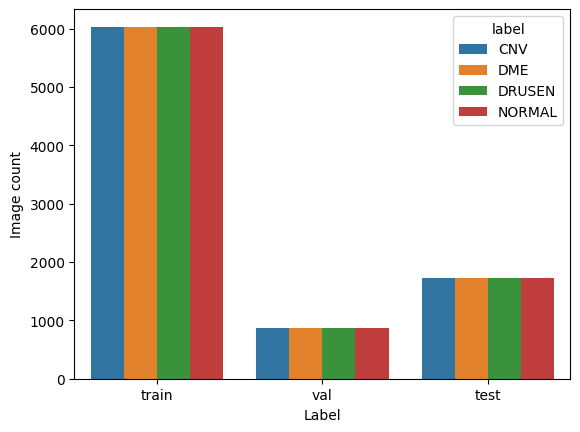

In [7]:
def data_availability_per_label(split_dir):
    '''
    Exploring the either train, val or test directoties
    counts the number of files per label

    '''
    df = pd.DataFrame(columns=['split_dir', 'label', 'count'])
    for label in labels:
        image_labels = os.listdir(split_paths[split_dir] + '/' + label)
        count = 0
        for image_name in image_labels:
            count += 1
        df = df.append({'split_dir': split_dir, 'label': label, 'count': count},
                       ignore_index=True)

    return df


def data_availability():
    df = pd.DataFrame(columns=['split_dir', 'label', 'count'])
    for split_dir in split_dirs:
        df2 = data_availability_per_label(split_dir)
        df = df.append(df2)
    ax = sns.barplot(data=df, x='split_dir', y='count', hue='label')
    ax.set(xlabel='Label', ylabel='Image count')
    plt.savefig(f'{output_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
    plt.show()


data_availability()

## Data Augmentation

### Creating ImageDataGenerator

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Train dataset augmentation

In [9]:
batch_size = 20

train_set = augmented_image_data.flow_from_directory(split_paths['train'],
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 24136 images belonging to 4 classes.


{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

### Validation dataset augmentation

In [10]:
val_set = augmented_image_data.flow_from_directory(split_paths['val'],
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

val_set.class_indices

Found 3448 images belonging to 4 classes.


{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

### Test dataset augmentation

In [11]:
test_set = augmented_image_data.flow_from_directory(split_paths['test'],
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

test_set.class_indices

Found 6896 images belonging to 4 classes.


{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

(20, 170, 180, 3)


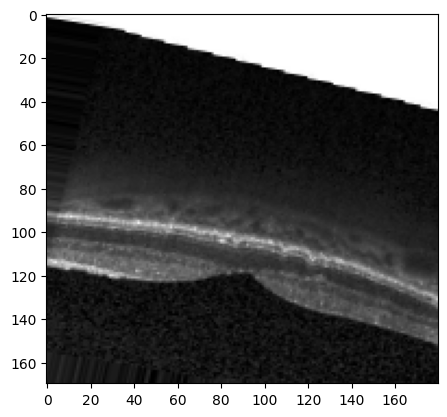

(20, 170, 180, 3)


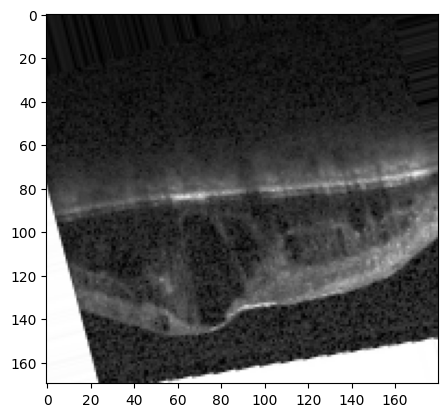

(20, 170, 180, 3)


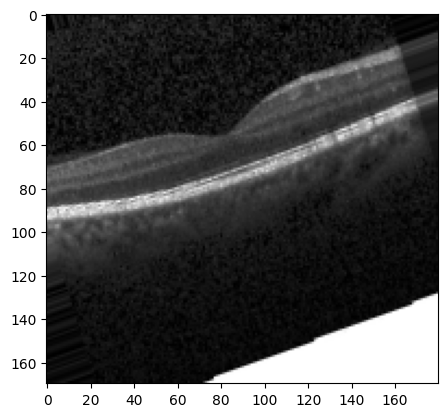

In [18]:
for i in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()


## ML model

### Import model packages

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D


### Defining a tunnable model

In [13]:
def create_multiclas_model(hp):
    '''
    The function allows to tune the model
    using the hyperband 'hp' attribute from keras
    defining search ranges for learning rate and number
    of units for the first Dense layer
    '''
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Defining range for number of units
    n_units = hp.Int('units', min_value=128, max_value=384, step=128)
    model.add(Dense(units=n_units, activation='relu'))

    model.add(Dropout(0.5))

    model.add(Dense(4, activation='softmax'))
    # Defining range for learning rates
    learning_rate = hp.Choice('learning_rate', values=[5e-4, 1e-3])
    adam_learning_rate = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam_learning_rate,
                  metrics=['accuracy'])

    return model

### Tuning Hyperparameters for model

In [14]:
%pip install keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 129 kB 5.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/gitpod/.pyenv/versions/3.8.12/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
from tensorflow import keras
from keras_tuner import Hyperband

model_tuner = Hyperband(
    create_multiclas_model,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='oct_dir',
    project_name='model_hyper_tunning_oct_reader'
)

2024-03-26 13:52:12.285512: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Adding early stop

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
patience = 3
early_stop = EarlyStopping(monitor='val_loss', patience=patience)


### Create serch for model_tuner

In [24]:
model_tuner.search(
    train_set,
    epochs=20,
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_data=val_set,
    callbacks=[early_stop],
    verbose=2
)

Trial 6 Complete [00h 27m 05s]
val_accuracy: 0.5954176187515259

Best val_accuracy So Far: 0.6386311054229736
Total elapsed time: 03h 43m 16s


In [27]:
best_hps = model_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal number of units is {best_hps['units']}")
print(f"The optimal learning rate is {best_hps['learning_rate']}")

The optimal number of units is 256
The optimal learning rate is 0.0005


In [16]:
import joblib
joblib.dump(value=best_hps,
            filename=os.path.join(output_path, 'best_hps_file.pkl'))

NameError: name 'best_hps' is not defined

In [17]:
best_hps_recall=joblib.load(f'{output_path}/best_hps_file.pkl')
print(f"The optimal number of units is {best_hps_recall['units']}")
print(f"The optimal learning rate is {best_hps_recall['learning_rate']}")

The optimal number of units is 256
The optimal learning rate is 0.0005


In [20]:
model = model_tuner.hypermodel.build(best_hps_recall)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 168, 178, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 84, 89, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 82, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 41, 43, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 39, 41, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 20, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24320)            

In [21]:
model.fit(train_set,
          epochs=20,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=val_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-03-26 13:53:32.788640: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
1206/1206 [==============================] - 653s 541ms/step - loss: 1.2170 - accuracy: 0.4288 - val_loss: 1.0464 - val_accuracy: 0.5325
Epoch 2/20
1206/1206 [==============================] - 673s 558ms/step - loss: 1.0247 - accuracy: 0.5437 - val_loss: 0.9691 - val_accuracy: 0.5716
Epoch 3/20
1206/1206 [==============================] - 627s 519ms/step - loss: 0.9710 - accuracy: 0.5803 - val_loss: 0.9218 - val_accuracy: 0.6096
Epoch 4/20
1206/1206 [==============================] - 607s 503ms/step - loss: 0.9241 - accuracy: 0.6108 - val_loss: 0.9008 - val_accuracy: 0.6288
Epoch 5/20
1206/1206 [==============================] - 594s 493ms/step - loss: 0.8674 - accuracy: 0.6434 - val_loss: 0.8325 - val_accuracy: 0.6766
Epoch 6/20
1206/1206 [==============================] - 765s 634ms/step - loss: 0.8168 - accuracy: 0.6735 - val_loss: 0.8724 - val_accuracy: 0.6383
Epoch 7/20
1206/1206 [==============================] - 723s 600ms/step - loss: 0.7599 - accuracy: 0.6995 - val_

### Saving model

In [23]:
model.save(f'{output_path}/OCTreader_model.h5')

## Model performance

### Model learning curves

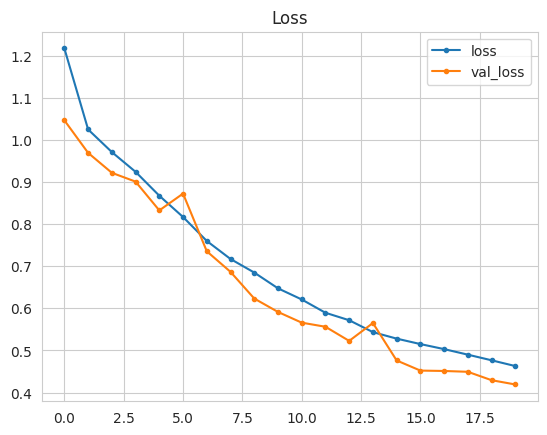

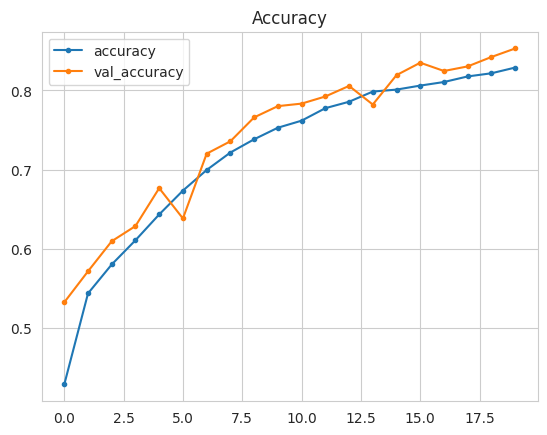

In [22]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{output_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{output_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model evaluation

### Uploading model

In [5]:
from keras.models import load_model
model = load_model(f'{output_path}/OCTreader_model.h5')

OSError: SavedModel file does not exist at: outputs/v3/OCTreader_model.h5/{saved_model.pbtxt|saved_model.pb}

### Evaluating using test dataset

In [24]:
evaluation = model.evaluate(test_set)

345/345 [==============================] - 80s 231ms/step - loss: 0.4138 - accuracy: 0.8531


### Saving evaluation

In [41]:
joblib.dump(value=evaluation, filename=f"{output_path}/evaluation.pkl")

['outputs/v3/evaluation.pkl']

## Predicting data

### Load an image randomly

DRUSEN
Image shape: (180, 170), Image mode: RGB


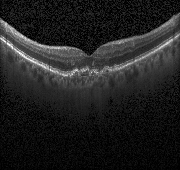

In [26]:
import random
from tensorflow.keras.preprocessing import image


test_path = split_paths['test']
labels = os.listdir(test_path)
my_label = random.choice(labels)
label_path = test_path + '/' + my_label
image_list = os.listdir(label_path)
random_image = random.choice(image_list)

print(my_label)
pred_image = image.load_img(label_path + '/' + random_image,
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pred_image.size}, Image mode: {pred_image.mode}')
pred_image

### Image conversion to array

In [27]:
my_image = image.img_to_array(pred_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 170, 180, 3)


### Predicting class probability

In [28]:
target_map = {v: k for k, v in train_set.class_indices.items()}
target_map

{0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}

In [29]:
pred_proba = model.predict(my_image)
max_prob_pos = np.argmax(pred_proba)

target_map = {v: k for k, v in train_set.class_indices.items()}
print(pred_proba)
print(target_map[max_prob_pos])


[[4.4091183e-01 6.1412997e-05 5.5900860e-01 1.8138106e-05]]
DRUSEN


## Confusion matrix

### Create arrays for train, test and validation datasets

In [30]:
import random
from tensorflow.keras.preprocessing import image

def create_dataset_image_array(split_dir, n_images):
    X, y = np.array([], dtype='int'), np.array([], dtype='int')
    labels = os.listdir(split_dir)
    n_label = 0
    for label in labels:
        label_path = split_dir + '/' + label
        full_image_list = os.listdir(label_path)
        image_list = full_image_list[0: n_images]
        random.shuffle(image_list)
        for image_name in image_list:
            img = image.load_img(f'{label_path}/{image_name}', target_size=image_shape[:2])
            img_array = image.img_to_array(img)
            if img_array.max()>1:
                resized_img = img_array / 255
            else:
                resized_img = img_array
            
            X = np.append(X, resized_img).reshape(-1, image_shape[0], image_shape[1], 3)
            y = np.append(y, n_label)
        n_label += 1
    return X, y

X_train, y_train = create_dataset_image_array('inputs/OCTdata/train', 100)
X_val, y_val = create_dataset_image_array('inputs/OCTdata/val', 100)
X_test, y_test = create_dataset_image_array('inputs/OCTdata/test', 100)


### Preparing for prediction function

Confussion Matrix and Classification Report for Train dataset


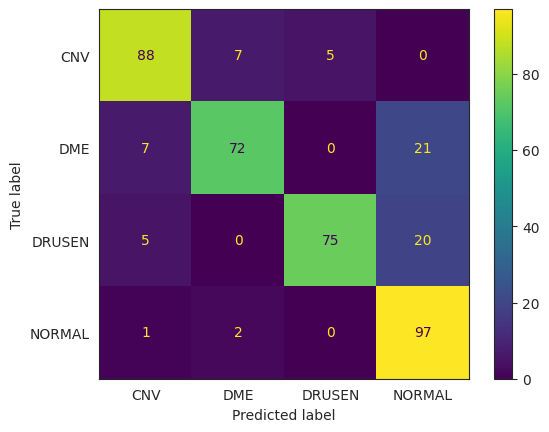

Classification Report
              precision    recall  f1-score   support

         CNV       0.87      0.88      0.88       100
         DME       0.89      0.72      0.80       100
      DRUSEN       0.94      0.75      0.83       100
      NORMAL       0.70      0.97      0.82       100

    accuracy                           0.83       400
   macro avg       0.85      0.83      0.83       400
weighted avg       0.85      0.83      0.83       400

Confussion Matrix and Classification Report for Val dataset


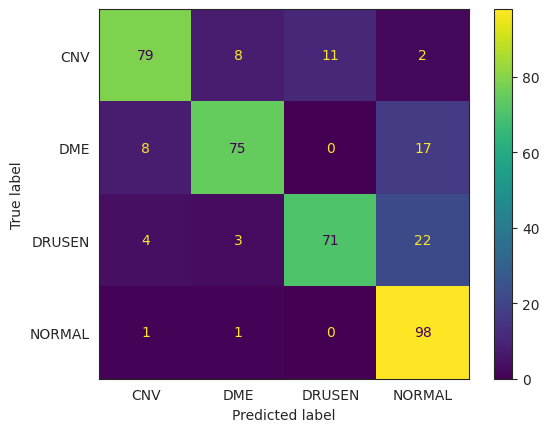

Classification Report
              precision    recall  f1-score   support

         CNV       0.86      0.79      0.82       100
         DME       0.86      0.75      0.80       100
      DRUSEN       0.87      0.71      0.78       100
      NORMAL       0.71      0.98      0.82       100

    accuracy                           0.81       400
   macro avg       0.82      0.81      0.81       400
weighted avg       0.82      0.81      0.81       400

Confussion Matrix and Classification Report for Test dataset


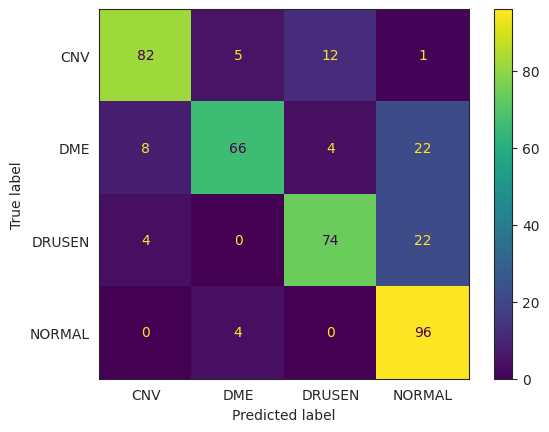

Classification Report
              precision    recall  f1-score   support

         CNV       0.87      0.82      0.85       100
         DME       0.88      0.66      0.75       100
      DRUSEN       0.82      0.74      0.78       100
      NORMAL       0.68      0.96      0.80       100

    accuracy                           0.80       400
   macro avg       0.81      0.79      0.79       400
weighted avg       0.81      0.80      0.79       400



In [40]:
from sklearn import metrics
import matplotlib.pyplot as plt
import joblib

sns.set_style('white')
def create_confission_matrix_report(X, y, split_set):
    pred_proba = model.predict(X)
    prediction = np.argmax(pred_proba, axis=1)
    confusion_matrix = metrics.confusion_matrix(y, prediction)
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['CNV', 'DME', 'DRUSEN', 'NORMAL'])
    cm_display.plot()
    plt.savefig(f'{output_path}/confussion_matrix_{split_set}.png',
            bbox_inches='tight', dpi=150)
    plt.show()
    print('Classification Report')
    class_report = metrics.classification_report(y, prediction, target_names=['CNV', 'DME', 'DRUSEN', 'NORMAL'])
    print(class_report)
    joblib.dump(value=class_report, filename=f"{output_path}/class_report_{split_set}.pkl")


print('Confussion Matrix and Classification Report for Train dataset')
create_confission_matrix_report(X_train, y_train, 'train')
print('Confussion Matrix and Classification Report for Val dataset')
create_confission_matrix_report(X_val, y_val, 'val')
print('Confussion Matrix and Classification Report for Test dataset')
create_confission_matrix_report(X_test, y_test, 'test')

In [39]:
    pred_proba = model.predict(X_val)
    prediction = np.argmax(pred_proba, axis=1)
    confusion_matrix = metrics.classification_report(y_val, prediction, target_names=['CNV', 'DME', 'DRUSEN', 'NORMAL'])

str